In [1]:
import psfmodels as psfm
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np
import tifffile
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean, rotate
from scipy.optimize import minimize, LinearConstraint, Bounds, differential_evolution, basinhopping, shgo, dual_annealing, direct




def get_midline(arr):
    mid_x = arr.shape[1]//2
    return arr[mid_x]

def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline

In [23]:
real_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif").astype(np.float32)
real_PSF = real_PSF[:,100:-100,100:-100]
original_z = real_PSF.shape[0]
real_PSF = real_PSF[(original_z - 41)//2:-(original_z - 41)//2]
#imshow(label_image, labels=True)
#stats = cle.statistics_of_labelled_pixels(real_PSF, label_image)

#df = pd.DataFrame(stats)
#df[["mass_center_x", "mass_center_y", "mass_center_z"]]
#real_PSF = real_PSF[int(df["mass_center_z"])]
real_PSF -= np.round(np.sort(real_PSF.flatten())[0:int(len(real_PSF.flatten())*.05)].mean()).astype(np.uint)
real_PSF -= real_PSF.min()
real_PSF = np.clip(real_PSF, 0, np.inf)
real_PSF = real_PSF / real_PSF.max()
real_PSF.shape

(41, 41, 41)

In [24]:
real_PSF.min()

0.0

In [25]:
PSF_depth = real_PSF.shape[0] * 0.05
slices = np.linspace(-PSF_depth/2, PSF_depth/2, real_PSF.shape[0])
def PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset):
    synthetic = psfm.make_psf(
        slices,
        nx = real_PSF.shape[1],
        dxy = 0.065/1.5,
        pz = pz,
        ti0 = ti0,
        ni0 = ni0,
        ni = ni, 
        tg0 = tg0,
        ng0 = ng0,
        ng = ng,
        ns = ns,
        wvl = 0.515,
        NA = NA,
        model = "vectorial"
        ) + offset
    #synthetic -= synthetic.min()
    synthetic = synthetic / synthetic.max()
    return synthetic

def error_function(params):
    pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset = params
    #if (NA > ni) or (NA > ni0) or (pz < 0):
    #    return 1000
    synthetic = PSF_function(pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset)
    return np.nansum((real_PSF - synthetic) ** 2)

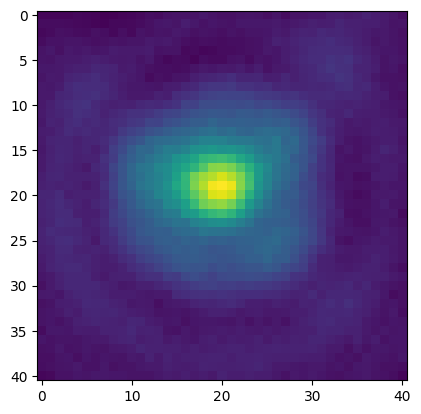

In [26]:
plt.imshow(real_PSF[0])

nx (int):       XY size of output PSF in pixels, must be odd.
dxy (float):    pixel size in sample space (microns) [default: 0.05]
pz (float):     depth of point source relative to coverslip (in microns) [default: 0]
ti0 (float):    working distance of the objective (microns) [default: 150.0]
ni0 (float):    immersion medium refractive index, design value [default: 1.515]
ni (float):     immersion medium refractive index, experimental value [default: 1.515]
tg0 (float):    coverslip thickness, design value (microns) [default: 170.0]
tg (float):     coverslip thickness, experimental value (microns) [default: 170.0]
ng0 (float):    coverslip refractive index, design value [default: 1.515]
ng (float):     coverslip refractive index, experimental value [default: 1.515]
ns (float):     sample refractive index [default: 1.47]
wvl (float):    emission wavelength (microns) [default: 0.6]
NA (float):     numerical aperture [default: 1.4]


In [27]:
params = [0, 140, 1.518, 1.518, 170, 170, 1.515, 1.515, 1.47, 1.49, 0]
pz, ti0, ni0, ni, tg0, tg, ng0, ng, ns, NA, offset = params

In [28]:
bounds = Bounds([0, 100, 1.49, 1.49, 100, 100, 1.5, 1.5, 1.3, 1.3, 0], [5, 200, 1.6, 1.6, 200, 200, 2, 2, 2, 1.4899, 1])

In [29]:
def check_zero_cost(intermediate_result):
    if intermediate_result.fun == 0:
        print(f"Cost is zero for parameters: {intermediate_result.x}")
    return False  # return True if you want to stop the optimization here


In [ ]:
%%time 
result = differential_evolution(error_function, bounds, workers = 23, disp = True, callback = check_zero_cost)

/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


differential_evolution step 1: f(x)= 197.27317213647422
differential_evolution step 2: f(x)= 141.61827336947698
differential_evolution step 3: f(x)= 141.61827336947698
differential_evolution step 4: f(x)= 55.68693739861241
differential_evolution step 5: f(x)= 55.68693739861241
differential_evolution step 6: f(x)= 55.68693739861241
differential_evolution step 7: f(x)= 55.68693739861241
differential_evolution step 8: f(x)= 55.68693739861241
differential_evolution step 9: f(x)= 55.68693739861241
differential_evolution step 10: f(x)= 43.01402633530746
differential_evolution step 11: f(x)= 43.01402633530746
differential_evolution step 12: f(x)= 43.01402633530746
differential_evolution step 13: f(x)= 43.01402633530746
differential_evolution step 14: f(x)= 26.65694337303232
differential_evolution step 15: f(x)= 26.65694337303232
differential_evolution step 16: f(x)= 26.65694337303232
differential_evolution step 17: f(x)= 16.282253021572405
differential_evolution step 18: f(x)= 16.282253021572

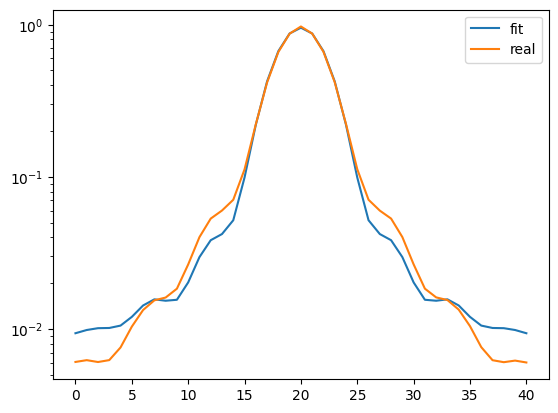

In [31]:
fitted_PSF = PSF_function(*result.x)
mid_z = fitted_PSF.shape[0]//2 
plt.plot(get_midline(fitted_PSF[mid_z]), label ="fit")
plt.plot(get_midline_rotate_method(real_PSF[mid_z]), label = "real")
plt.yscale("log")
plt.legend()

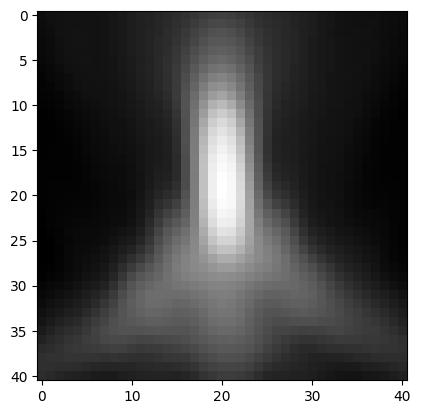

In [32]:
plt.imshow(real_PSF.sum(axis=1), cmap = "Greys_r")

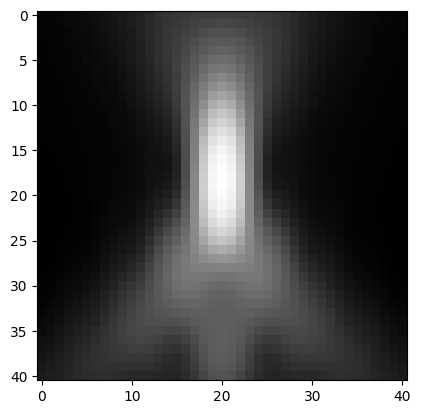

In [33]:
plt.imshow(fitted_PSF.sum(axis=1), cmap = "Greys_r")

In [37]:
import pickle
with open('PSF_fitted_for_single_molecule_50nm_pix_xyz_params.pkl', 'wb') as file: 
      
    # A new file will be created 
    pickle.dump(result, file) 

tifffile.imwrite("PSF_fitted_for_single_molecule_50nm_pix_xyz.tif", fitted_PSF)

In [36]:
fitted_PSF.shape

(41, 41, 41)